In [35]:
from drn_interactions.interactions.loaders import SpontaneousActivityLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr, PairwisePartialCorr
from drn_interactions.interactions.popcup import PopulationCoupling
from drn_interactions.interactions.runners import InteractionsRunner
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.config import Config, ExperimentInfo
import numpy as np
from drn_interactions.interactions.graph import GraphAttributes, NodeAttributes
import pandas as pd
import seaborn as sns
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer

fig_dir = Config.fig_dir
sns.set_theme(style='ticks', context="paper")

In [2]:
neuron_types = load_derived_generic("neuron_types.csv")[
    ["neuron_id", "neuron_type", "session_name"]
]
sessions = neuron_types["session_name"].dropna().unique()
res_corr = []
res_pcorr = []
res_pcup = []
bin_widths = [0.05, 0.1, 0.5, 1, ]

loader_fac = lambda bin_width, shuffle: SpontaneousActivityLoader(
    session_name=sessions[0], bin_width=bin_width, shuffle=shuffle
)
preprocessor_fac = lambda: InteractionsPreprocessor(
    z=True, minmax=False, gaussian_sigma=None
)
corr_fac = lambda: PairwiseCorr()
pcorr_fac = lambda: PairwisePartialCorr()
pcup_fac = lambda: PopulationCoupling()

runner_fac = lambda bin_width, shuffle: InteractionsRunner(
    loader=loader_fac(bin_width, shuffle),
    preprocessor=preprocessor_fac(),
    pcup=pcup_fac(),
    corr=corr_fac(),
    pcorr=pcorr_fac(),
)
for shuffle in (True, False):
    for bin_width in bin_widths:
        runner = runner_fac(bin_width, shuffle)
        res_pcorr.append(runner.run_pcorr_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle))
        res_corr.append(runner.run_corr_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle))
        res_pcup.append(runner.run_pcup_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle))

rsc = (
    pd.concat(res_corr)
    .reset_index(drop=True)
    .rename(columns=dict(corr="value"))
    .assign(metric="rsc")
    .assign(mag=lambda x: np.abs(x["value"]))
)
pcorr = (
    pd.concat(res_pcorr)
    .reset_index(drop=True)
    .rename(columns=dict(pcorr="value"))
    .assign(metric="pcorr")
    .assign(mag=lambda x: np.abs(x["value"]))
)
pcup = (
    pd.concat(res_pcup)
    .reset_index(drop=True)
    .rename(columns=dict(cc="value"))
    .assign(metric="pcup")
    .assign(mag=lambda x: np.abs(x["value"]))
)

c:\users\roryl\repos\drn interactions\drn_interactions\interactions\cross_correlations.py:25: RuntimeWarning: invalid value encountered in true_divide
  return lags, cvf / (np.std(x) * np.std(y))


In [4]:
graph_attrs = GraphAttributes(inverse_distance=True)

df_distance = load_distances()
sessions = neuron_types["session_name"].dropna().unique()
graph_dfs = []

for bin_width in (0.05, 0.1, 0.5, 1):
    for shuffle_higher in (False, True):
        for session in sessions:
            loader = SpontaneousActivityLoader(
                session_name=session, bin_width=bin_width, block="pre", t_start=0, t_stop=1800
            )
            preprocessor = InteractionsPreprocessor()
            pairwise = PairwiseCorr(rectify=True, shuffle=shuffle_higher)

            spikes = preprocessor(loader())
            df_affinity = (
                pairwise.fit(spikes)
                .get_adjacency_df()
                .dropna(axis=1, thresh=5)
                .dropna(axis=0, thresh=5)
            )
            
            G = df_to_graph(df_affinity, rename_nodes=True)
            graph_stats = graph_attrs.get_graph_attributes(G).assign(
                session=session, shuffle=shuffle_higher, bin_width=bin_width
                )
            graph_dfs.append(graph_stats)

df_graph = pd.concat(graph_dfs).reset_index(drop=True)

c:\users\roryl\repos\drn interactions\drn_interactions\interactions\network.py:92: RuntimeWarning: invalid value encountered in double_scalars
  delta_L = (L_obs - L_rand) / (L_latt - L_rand)


In [27]:

ensembles = (
    load_derived_generic("ensembles/spont - ensembles.csv")
    .groupby(["bin_width", "shuffle", "session_name"])["ensemble"]
    .nunique()
    .subtract(1)
    .to_frame("Number of Ensembles")
    .reset_index()
)

seqnmf = load_derived_generic("seqnmf_sequenciness_scores.csv").query("bin_width <= 1")

C:\Users\roryl\AppData\Local\Temp\ipykernel_16316\3352387949.py:36: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.subplots_adjust(hspace=0.7)


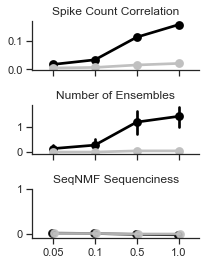

In [49]:
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK
sns.set_palette(PAL_GREY_BLACK)

f = plt.figure(figsize=(3, 4), constrained_layout=True)

ax = f.subplots(3, 1, sharex=True)
# f.subplots()


sns.pointplot(x="bin_width", y="mag", hue="shuffle", data=rsc, estimator=np.median, ax=ax[0])
ax[0].set_ylabel("")
ax[0].set_xlabel("")
ax[0].set_title("Spike Count Correlation",  fontsize=12)
# ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=19)

sns.pointplot(
    x="bin_width", 
    y="Number of Ensembles", 
    hue="shuffle", 
    data=ensembles,
    ax=ax[1]
    )
ax[1].set_ylabel("")
ax[1].set_xlabel("")
ax[1].set_title("Number of Ensembles",  fontsize=12)

g_seq = sns.pointplot(x="bin_width", y="score", hue="shuffle", data=seqnmf, estimator=np.median, ax=ax[2], dodge=True,)
ax[2].set_ylim(-0.1, 1)
plt.setp(g_seq.collections, alpha=.9)
plt.setp(g_seq.lines, alpha=.9) 
ax[2].set_ylabel("")
ax[2].set_xlabel("")
ax[2].set_title("SeqNMF Sequenciness", fontsize=12)

f.subplots_adjust(hspace=0.7)
for ax_ in ax:
    ax_.legend().remove()

sns.despine(fig=f)
f.savefig(fig_dir / "interactions by bin width.png", dpi=300)